In [2]:
import sys
sys.path.append('../')

from src.chainables import Chainable, ChainableObject, ChainableFunction, TypeSafeChainableFunction
from typing import List, Optional, Any, Union
from pprint import pprint

In [127]:
from pydantic import Field
import numpy as np

class Signals:
    pass
Chainable.Signal = Signals()

class SinusVoltageGenerator(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        label: Optional[dict[str, str]] = {'de':"Spannungssignal", 'en':"Voltage signal"}
        frequency_Hz : Optional[float] = 1.0
        amplitude_V: Optional[float] = 1.0
        sample_duration_s: Optional[float] = 1.0
        sampling_frequency_Hz: Optional[float] = 100.0
        
    class Data(TypeSafeChainableFunction.Data):
        signal: np.ndarray# = Field(default_factory=lambda: np.zeros(0,0))
        
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
        label: dict[str, str]
        column_labels: dict[str, List[str]]
        column_quantities: List[str]
        column_units: List[str]
    
    def __init__(self):
        super(__class__, self).__init__(name="sinus_voltage_generator", uuid="f4e25e06-5307-464c-8b07-c3f3033a798d", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

    def func(self, param):
        sample_interval_s = 1.0/param.sampling_frequency_Hz
        x = np.arange(0, param.sample_duration_s, sample_interval_s)
        y = np.sin(2 * np.pi * param.frequency_Hz * x)
        signal = np.vstack((x, y)).T
        super().store('signal', 
                      {'signal': signal}, 
                      {'name': param.data_name, 
                       'label': param.label, 
                       'column_labels': {'de': ["Zeit", "Spannung"], 'en': ["Time", "Voltage"]},
                       'column_quantities': ["qudt:Time", "qudt:Voltage"], 
                       'column_units': ["s", "V"], 
                      }
                     )
Chainable.Signal.sinus_voltage_generator = SinusVoltageGenerator()

class SignalAddition(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        signals: Union[np.ndarray, List[np.ndarray]]
        label: Optional[dict[str, str]] = {'de':"Summensignal", 'en':"Sum signal"}
        
    class Data(TypeSafeChainableFunction.Data):
        signal: np.ndarray
    
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
        label: dict[str, str]
        
    def __init__(self):
        super(__class__, self).__init__(name="signal_addition", uuid="919e6981-59dd-45f5-ad46-f05e6b0f0c49", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

        
    def func(self, param):
        if (type(param.signals) == np.ndarray): param.signals = [param.signals]
        #TODO: Check zero len, dimensions, etc.
        signal = param.signals[0] 
        for i in range(1, len(param.signals)):
            signal[:,1] += param.signals[i][:,1]
        super().store('signal',
                      {'signal': signal}, 
                      {'name': param.data_name, 
                       'label': param.label,
                      }
                     )
Chainable.Signal.signal_addition = SignalAddition()

from scipy.signal import butter, sosfilt, sosfreqz#, lfilter
class BandpassFilter(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        signals: Union[np.ndarray, List[np.ndarray]]
        label: Optional[dict[str, str]] = {'de':"Gefiltertes Signal", 'en':"Filtered signal"}
        order: Optional[int] = 1
        lower_cut_frequency_Hz: float
        higher_cut_frequency_Hz: float
        sampling_frequency_Hz: float
        
    class Data(TypeSafeChainableFunction.Data):
        signals: Union[np.ndarray, List[np.ndarray]]
    
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
        label: dict[str, str]
        
    def __init__(self):
        super(__class__, self).__init__(name="bandpass_filter", uuid="2c02238b-1ce8-4f49-ac33-e2630933e8c7", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

        
    def func(self, param):
        if (type(param.signals) == np.ndarray): param.signals = [param.signals]
        signals = []
        order = param.order
        #lowcut = param.lower_cut_frequency_Hz
        #highcut = param.higher_cut_frequency_Hz
        fs = param.sampling_frequency_Hz
        #b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
        nyq = 0.5 * fs
        low = param.lower_cut_frequency_Hz# / nyq
        high = param.higher_cut_frequency_Hz# / nyq
        print(order, fs, nyq, low, high)
        sos = butter(order, [low, high], analog=False, btype='band', output='sos', fs=fs)
        #sos = butter(order, high, analog=False, btype='lowpass', output='sos', fs=fs)
        if param.debug:
            w, h = sosfreqz(sos, worN=2000)
            fig = plt.figure()
            ##plt.plot(w, abs(h), label="order = %d" % order, figure=fig)
            plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order, figure=fig)
        for i in range(0, len(param.signals)):
            signal = param.signals[i]
            #signal[:,1] = lfilter(b, a, param.signals[i][:,1])
            signal[:,1] = sosfilt(sos, param.signals[i][:,1])
            signals.append(signal)
        super().store('signal',
                      {'signals': signals}, 
                      {'name': param.data_name, 
                       'label': param.label,
                      }
                     )
Chainable.Signal.bandpass_filter = BandpassFilter()
    
import matplotlib
import matplotlib.pyplot as plt 
class SignalPlot(TypeSafeChainableFunction):
    class Param(TypeSafeChainableFunction.Param):
        data_name: str
        signals: Union[np.ndarray, List[np.ndarray]]# = Field(default_factory=lambda: np.zeros(0,0))
        labels: Optional[Union[str, List[str]]] = []
        axis_labels: Optional[Union[str, List[str]]] = []
        axis_units: Optional[Union[str, List[str]]] = []
        title: str = "Signal plot"
        
    class Data(TypeSafeChainableFunction.Data):
        #pass
        figure: matplotlib.figure.Figure
        
    class Meta(TypeSafeChainableFunction.Meta):
        name: str
    
    def __init__(self):
        super(__class__, self).__init__(name="signal_plot", uuid="a21d3dc4-efcb-48eb-a951-85ef0050b3bf", param_class=__class__.Param, data_class=__class__.Data, meta_class=__class__.Meta)

    def func(self, param):
        fig = plt.figure()

        if (type(param.signals) == np.ndarray): param.signals = [param.signals]
        if (type(param.labels) == str): param.labels = [param.labels]
        if (type(param.axis_labels) == str): param.axis_labels = [param.axis_labels]
        if (type(param.axis_units) == str): param.axis_units = [param.axis_units]
        
        for (index,signal) in enumerate(param.signals):
            label = ""
            if len(param.labels) > index: label = param.labels[index]
            plt.plot(signal[:,0], signal[:,1], label=label, figure=fig)
            
        for (index,axis_label) in enumerate(param.axis_labels):
            unit = ""
            if len(param.axis_units) > index: unit = f" [{param.axis_units[index]}]"
            if (index == 0): plt.xlabel(f"{axis_label}{unit}", figure=fig)
            if (index == 1): plt.ylabel(f"{axis_label}{unit}", figure=fig)
            
        plt.title(param.title, figure=fig)
        plt.legend(loc="upper left")
        super().store('plot', 
                      {'figure': fig}, 
                      {'name': param.data_name, 
                      }
                     )
Chainable.Signal.signal_plot = SignalPlot()      

10 100.0 50.0 0.01 2.0


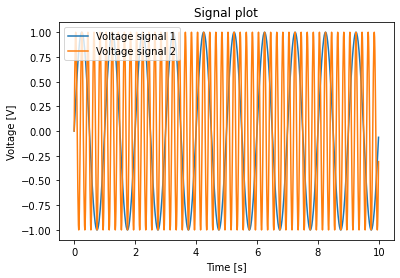

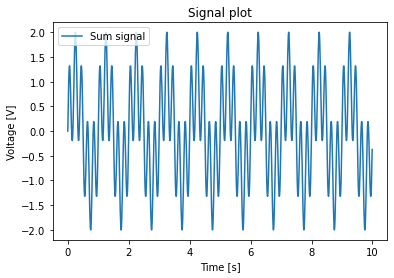

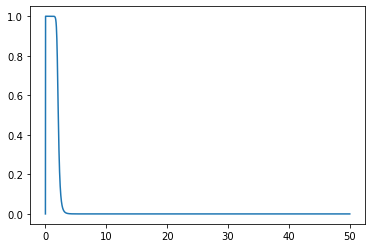

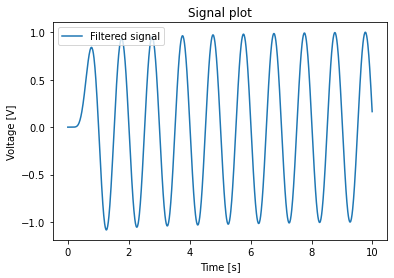

In [137]:
obj = ChainableObject()
lang = 'en'
obj = obj.apply({
    'func': "Chainable.Signal.sinus_voltage_generator",
    'param': {'debug': False, 'data_name': "signal1", 'frequency_Hz': 1, 'sample_duration_s': 10, 'sampling_frequency_Hz': 100, 'label': {'static': {'de':"Spannungssignal 1", 'en':"Voltage signal 1"}}}
}).apply({
    'func': "Chainable.Signal.sinus_voltage_generator",
    'param': {'debug': False, 'data_name': "signal2", 'frequency_Hz': 5, 'sample_duration_s': 10, 'sampling_frequency_Hz': 100, 'label': {'static': {'de':"Spannungssignal 2", 'en':"Voltage signal 2"}}}
}).apply({
    'func': "Chainable.Signal.signal_plot",
    'param': {'debug': False, 'data_name': "plot1", 
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name =~ "signal"]'}}, 'value': {'data': {'jsonpath': 'signal'}}}, #default: traverse to data branch
              'labels': {'match': {'meta': {'jsonpath': 'meta.*[?name =~ "signal"]'}}, 'value': {'meta': {'jsonpath': f'label.{lang}'}}}, #value path relative to match path
              'axis_labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': f'column_labels.{lang}'}}},
              'axis_units': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': 'column_units'}}},
             }
}).apply({
    'func': "Chainable.Signal.signal_addition",
    'param': {'debug': False, 'data_name': "merged_sig", 
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name =~ "signal"]'}}, 'value': {'data': {'jsonpath': 'signal'}}}, #default: traverse to data branch   
             }
}).apply({
    'func': "Chainable.Signal.signal_plot",
    'param': {'debug': False, 'data_name': "plot2", 
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name = "merged_sig"]'}}, 'value': {'data': {'jsonpath': 'signal'}}}, #default: traverse to data branch
              'labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "merged_sig"]'}}, 'value': {'meta': {'jsonpath': f'label.{lang}'}}}, #value path relative to match path
              'axis_labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': f'column_labels.{lang}'}}},
              'axis_units': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': 'column_units'}}},
             }
}).apply({
    'func': "Chainable.Signal.bandpass_filter",
    'param': {'debug': True, 'data_name': "filtered_signal",
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name = "merged_sig"]'}}, 'value': {'data': {'jsonpath': 'signal'}}}, #default: traverse to data branch 
              'order': 10, 'lower_cut_frequency_Hz': 0.01, 'higher_cut_frequency_Hz': 2, 'sampling_frequency_Hz': 100,
             }
}).apply({
    'func': "Chainable.Signal.signal_plot",
    'param': {'debug': False, 'data_name': "plot3", 
              'signals': {'match': {'meta': {'jsonpath': 'meta.*[?name = "filtered_signal"]'}}, 'value': {'data': {'jsonpath': 'signals'}}}, #default: traverse to data branch
              'labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "filtered_signal"]'}}, 'value': {'meta': {'jsonpath': f'label.{lang}'}}}, #value path relative to match path
              'axis_labels': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': f'column_labels.{lang}'}}},
              'axis_units': {'match': {'meta': {'jsonpath': 'meta.*[?name = "signal1"]'}}, 'value': {'meta': {'jsonpath': 'column_units'}}},
             }
})
#pprint(obj.dict())